In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Retrieve the MOCs of P/SDSS9/color and II/337/vvv1

In [2]:
from astroquery.cds import cds
from mocpy import MOC

In [3]:
sdss9 = cds.find_datasets("ID=CDS/P/SDSS9/color", return_moc=True)
vvv1 = cds.find_datasets("ID=CDS/II/337/vvv1", return_moc=True)

`sdss9` and `II_337_vvv1` are `mocpy.MOC` objects. One can use them e.g. for computing their intersection. This will give us a new `mocpy.MOC` instance of maximum HEALPix order : $\max( order_{sdss9}, order_{II/337/vvv1})$

In [4]:
moc = sdss9.intersection(vvv1)
moc.max_order

12

`mocpy.MOC` class has a `fill` method responsible for plotting the HEALPix cells of a MOC on a predefined matplotlib axe. This method accepts an `astropy.wcs.WCS` object along with a `matplotlib.axes.Axes` and some matplotlib style keyword arguments.

The next cell of code will define a matplotlib context and use it for drawing the `SDSS9` and `II/337/vvv1` MOCs along with their intersection MOC.

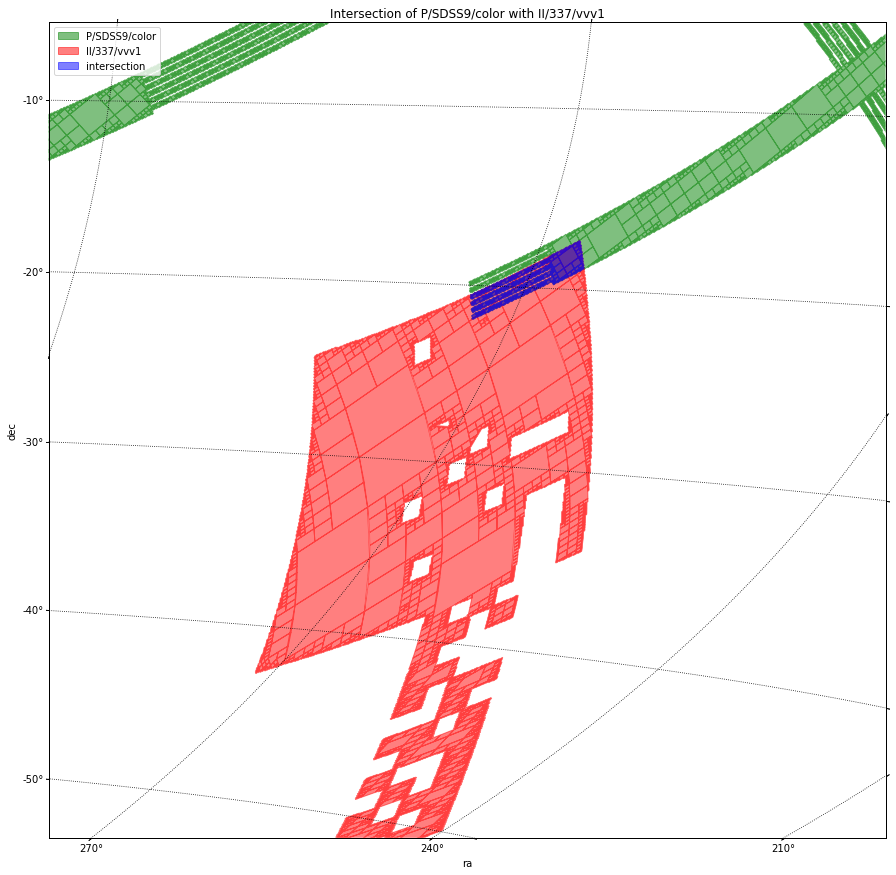

In [5]:
import matplotlib.pyplot as plt
from mocpy.spatial.utils import make_wcs

# MOCPy offers a way to easily create an `astropy.wcs.WCS` object.
# This define an ICRS aitoff projection.
wcs = make_wcs(crpix=[0, 0], crval=[0, 0], cdelt=[-5, 5], ctype=["RA---AIT", "DEC--AIT"])

# Create an mpl axe
fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw={"projection": wcs})

# Calls to `mocpy.MOC.fill` for each of the three MOCs with various mpl styling keywords
# to differentiate them from each other.
sdss9.fill(ax=ax, wcs=wcs, edgecolor='g', facecolor='g', linewidth=1.0, fill=True, alpha=0.5, label='P/SDSS9/color')
vvv1.fill(ax=ax, wcs=wcs, edgecolor='r', facecolor='r', linewidth=1.0, fill=True, alpha=0.5, label='II/337/vvv1')
moc.fill(ax=ax, wcs=wcs, edgecolor='b', facecolor='b', linewidth=1.0, fill=True, alpha=0.5, label='intersection')

plt.axis('equal')
plt.xlabel('ra')
plt.ylabel('dec')
plt.xlim(10, 20)
plt.ylim(-8, -6)
plt.title('Intersection of P/SDSS9/color with II/337/vvv1')
plt.grid(color="black", linestyle="dotted")
plt.legend(loc='upper left')
plt.show()
plt.close()

At this point we have retrieved MOC objects from the MOCServer using `astroquery.cds`. Then we used `mocpy` to compute their intersection which gave us a new MOC.

We will use this MOC for filtering a vizier catalog. Querying the MOCServer using `astroquery.cds` can help us knowing which vizier tables have sources in our MOC. As `astroquery.cds.query_region` returns an `astropy.table.Table`, it is also possible to do some post-filtering on the large amount of tables we might receive.

------

## Retrieve a Vizier Table and filter it through a MOC

In [6]:
data_cols = cds.query_region(moc)

As the returned object is an `astropy.table.Table`, one can use mask arrays to filter the table.

In [7]:
mask = (data_cols['obs_regime'] == 'Optical') & \
    (data_cols['dataproduct_type'] == 'catalog') & \
    (data_cols['nb_rows'] < 10000) & (data_cols['nb_rows'] > 9000)
col = data_cols[mask]['obs_id', 'obs_title', 'dataproduct_type', 'cs_service_url', 'nb_rows']
col

obs_id,obs_title,dataproduct_type,cs_service_url,nb_rows
str28,str91,object,str91,float64
II/143A/catalog,"Guide Star Photometric Catalog, Updated Version 1 (Lasker+ 1988,1996) (catalog)",catalog,http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=II%2F143A%2Fcatalog&,9518.0
II/226/catalog,"Stellar polarization catalogs agglomeration (Heiles, 2000) (catalog)",catalog,http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=II%2F226%2Fcatalog&,9286.0
III/148A/table1,Interstellar lines catalogue (Garcia 1991) (table1),catalog,http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=III%2F148A%2Ftable1&,9917.0
J/A+A/376/441/stars,"Absolute proper motions of 112 open clusters (Dias+, 2001) (stars)",catalog,http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=J%2FA%2BA%2F376%2F441%2Fstars&,9886.0
V/14/catalog,Estimated astrophysical parameters from uvby (Philip+ 1980) (catalog),catalog,http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=V%2F14%2Fcatalog&,9054.0
V/50/catalog,"Bright Star Catalogue, 5th Revised Ed. (Hoffleit+, 1991) (catalog)",catalog,http://vizier.u-strasbg.fr/viz-bin/votable/-A?-source=V%2F50%2Fcatalog&,9110.0


Let's retrieve the `J/A+A/376/441/stars` table, filter it through our MOC and plot it to an aladin-lite view using ipyaladin.

First, let's use `astroquery.vizier` to get the full table.

In [8]:
J_A_A_376_441_stars_id = (col['obs_id'] == 'J/A+A/376/441/stars')
catalog = col[J_A_A_376_441_stars_id]
from astroquery.vizier import Vizier

v = Vizier(columns=['*', '_RAJ2000', '_DEJ2000'])
v.ROW_LIMIT = -1
table = v.get_catalogs(catalog['obs_id'])[0]
table

_RAJ2000,_DEJ2000,Cl,RAJ2000,e_RAJ2000,DEJ2000,e_DEJ2000,VTmag,pmRA,e_pmRA,pmDE,e_pmDE,Pr
deg,deg,,"""h:m:s""",mas,"""d:m:s""",mas,mag,mas / yr,mas / yr,mas / yr,mas / yr,%
float64,float64,bytes7,bytes13,int16,bytes13,int16,float32,float32,float32,float32,float32,int16
122.678262778,49.460816944,blanco1,08 10 42.7831,106,+49 27 38.941,108,12.95,2.00,3.40,2.80,3.20,0
122.398412500,49.450475000,blanco1,08 09 35.6190,30,+49 27 01.710,32,10.53,-3.40,2.10,8.40,2.00,1
122.709776111,48.913903056,blanco1,08 10 50.3463,30,+48 54 50.051,32,10.70,-3.60,2.00,2.40,2.00,18
122.402980278,49.193966944,blanco1,08 09 36.7153,9,+49 11 38.281,8,8.87,-8.30,1.10,6.30,1.10,67
122.631072222,49.108395000,blanco1,08 10 31.4573,11,+49 06 30.222,11,9.36,-5.90,1.20,4.90,1.10,70
122.463969722,49.187586111,blanco1,08 09 51.3527,11,+49 11 15.310,12,9.31,-7.20,1.70,5.20,1.60,79
122.454870556,49.417973056,blanco1,08 09 49.1689,21,+49 25 04.703,24,9.78,-1.80,2.10,5.40,2.00,1
122.785866389,49.004483889,blanco1,08 11 08.6079,17,+49 00 16.142,16,9.82,-5.30,1.90,4.80,1.80,60


We can filter this table to keep only the observations lying in the MOC. The sources from the filtered table are added to an aladin lite view along with the MOC.

In [9]:
import ipyaladin as ipyal
aladin= ipyal.Aladin(target='17 56 -18 59', fov=15)
aladin

Aladin(fov=15.0, options=['target', 'show_frame', 'allow_full_zoomout', 'show_share_control', 'show_zoom_control', 'fov', 'overlay_survey', 'survey', 'show_fullscreen_control', 'show_reticle', 'show_catalog', 'reticle_color', 'show_goto_control', 'coo_frame', 'overlay_survey_opacity', 'show_coo_grid', 'show_layers_control', 'full_screen', 'reticle_size', 'log'], target='17 56 -18 59')

In [10]:
# Add the MOC to the view
aladin.add_moc_from_dict(moc.serialize(format='json'), {
     'opacity': 0.5,
     'color': "#880000",
})


mask = moc.contains(table['_RAJ2000'], table['_DEJ2000'])
table_f = table[mask]
aladin.add_table(table_f)

## A new TMOC class in MOCPy for Creating Temporal Multi-Order Coverage Maps

A new `TMOC` class allows the user to create, save and manipulate temporal MOCs. This feature has been merged in the master branch of MOCPy the 30th of May.

In the following we will retrieve the second table of the vizier catalog ``II/285`` and create an `astropy.time.Time` from its `JD` named column. The method `from_times` creates a TMOC from an `astropy.time.Time` object. We plot the TMOC and print some informations such as the maximum resolution of the TMOC, the first and last date of observation and the total duration of the observations.

In [11]:
from astroquery.vizier import Vizier

viz = Vizier(columns=['*', '_RAJ2000', '_DEJ2000'])
viz.ROW_LIMIT = -1
table = viz.get_catalogs('II/285')[1]

print(table)

 Name  Ref      JD       Vmag  U-B  B-V    V-Rc  Rc-Ic  V-Ic 
                d        mag   mag  mag    mag    mag   mag  
------ --- ------------ ------ --- ------ ------ ----- ------
 T ANT 978 2443914.3750     --  --  0.802  0.391    --  0.856
 T ANT 978 2443915.4410     --  --  0.861  0.460    --  0.803
 T ANT 978 2444297.4250  9.360  --  0.791  0.431    --  0.840
 T ANT 978 2444298.4760  9.520  --  0.853  0.463    --  0.903
 T ANT 978 2444299.4940  9.720  --  0.927  0.484    --  0.953
 T ANT 978 2444300.4070  9.575  --  0.809  0.441    --  0.872
 T ANT 978 2444301.4180  8.881  --  0.499  0.309    --  0.608
 T ANT 978 2444302.4110  9.139  --  0.661  0.392    --  0.754
 T ANT 976 2451619.3105  9.738  --  0.910     --    --  0.959
 T ANT 976 2451619.3828     --  --     --     --    --  0.974
   ... ...          ...    ... ...    ...    ...   ...    ...
NN VUL 950 2445204.2187 14.102  --  1.372     --    --     --
NN VUL 950 2445205.2265 14.075  --  1.423     --    --     --
NN VUL 9

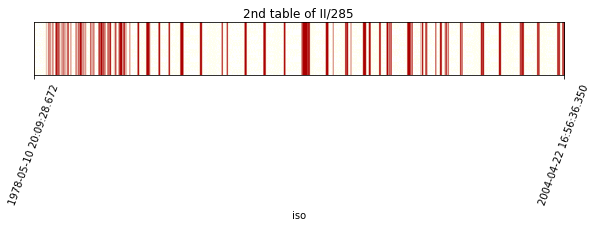

Time of the first observation: 1978-05-10 20:09:28.672
Time of the last observation: 2004-04-22 16:56:36.350
Total duration: 227.42448355555555 jd
max order: 14


In [12]:
from mocpy import TimeMOC
from astropy.time import Time

table_moc = TimeMOC.from_times(Time(table['JD'], format='jd', scale='tdb'))
table_moc.plot(title='2nd table of II/285')

# print characteristics such as the time of the first/last observations
print('Time of the first observation:', table_moc.min_time.iso)
print('Time of the last observation:', table_moc.max_time.iso)
# the total duration of the observation times
print('Total duration: {0} jd'.format(table_moc.total_duration.jd))
# the order of the TimeMoc
print('max order:', table_moc.max_order)